# PINN Introduction in PyTorch
- Video: https://www.youtube.com/watch?v=G_hIppUWcsc&list=LL&index=7&t=1642s

In [2]:
# import modules
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

- Modelling a damped harmonic oscillator (mass on the end of a spring)
- Differential equation:
$$ m\frac{d^2u}{dt} + \mu \frac{du}{dt} + ku=0 $$
- $m$ is mass, $\mu$ coeff. friction, $k$ spring constant
- In the underdamped state, oscillations are slowly damped by the friction. Occurs when:
$$ \delta < \omega_0 \ \ \text{where} \ \ \delta=\frac{\mu}{2m},\ \omega_0 = \sqrt{\frac{k}{m}}$$
- Initial conditions of system (displacement is 1, velocity is 0)
$$ u(t=0)=1, \ \frac{du}{dt}(t=0)=0 $$
- The exact analytical solution is:
$$ u(t) = e^{-\delta t}(2A\cos(\phi + \omega t)), \ \ \text{with} \ \ \omega=\sqrt{\omega_0^2 - \delta^2}  $$

## Workflow
1. Simulate the system using a PINN given the initial conditions
2. Invert for underlying parameters of the system using PINN given noisy observations of the oscillator's displacement

In [11]:
# define the exact analytical solution
def exact_solution(d, w0, t):
  # for underdamped case delta < w0
  assert d < w0

  w = np.sqrt(w0 ** 2 - d**2)
  phi = np.arctan(-d/w)
  A = 1/(2*np.cos(phi))
  # time is expected to be a torch tensor instead of numpy array
  cos = torch.cos(phi + w*t)
  exp = torch.exp(-d*t)

  u = exp*2*A*cos
  return u

# define fully connected network
class FCN(nn.Module):

  def __init__(self, num_input, num_output, num_neurons, num_layers):
    super().__init__()
    # use hyperbolic tangent for activation
    activation = nn.Tanh
    # define the first hidden layer (num_inputs to num_neurons)
    # nn.Sequential allows to define multiple layers in a sequence
    # for instance, a linear operation (weighted sum) is usually accompanied with activation, so use nn.Sequential to call linear then activation
    # rather than having two separate containers for the linear output and activated output
    self.input_layer = nn.Sequential(nn.Linear(num_input, num_neurons), activation())
    # define num_layers hidden layers in one container using nn.Sequntial
    # if using nn.Sequential within nn.Sequential, need to make as a list of modules and then unpack
    self.hidden_layer = nn.Sequential(*[nn.Sequential(nn.Linear(num_neurons, num_neurons), activation()) for _ in range(num_layers-1)])
    # define the output layer (no activation applied)
    self.output_layer = nn.Linear(num_neurons, num_output)

  def forward(self, x):
    x = self.input_layer(x)
    x = self.hidden_layer(x)
    x = self.output_layer(x)
    return x

## Training the Model
- The PINN directly approximates the solution to the differential equation
- $\theta$ is the weights of the NN, which are like parameters to the function
$$
u_{PINN} (t, \theta) \approx u(t)
$$
- The **loss function** is used to train the PINN to learn the underlying PDE, using the MSE
- The first term is the initial condition (displacement equals 1 at t=1)
- The second term is also initial condition (velocity equals 0 at t=0)
- The last term enforces the PDE (it is written in a shortform way, generally this loss term is written as PDE=0)
  - For N time sample points, compute the MSE for each time point, sum and get average loss
- Notice there is no term for dataloss, PINNs can be trained without a "dataset" and just on the expected PDE output
  - There is one datapoint given i.e) the boundary at t=0, dudt=1 but besides that it isn't told the value at other points in the domain
  - This is an example of unsupervised learning, since we aren't explicitly comparing the PINN results with an "expected output", only enforcing the physics
$$
\mathcal{L}(\theta) = (u_{PINN}(t=0, \theta)-1)^2 + \lambda_1 \left(\frac{d u_{PINN}}{dt}(t=0,\theta)-0 \right)^2 + \frac{\lambda_2}{N} \sum_i^N \left( \left[ m\frac{d^2}{dt^2}+\mu\frac{d}{dt}+k \right] u_{PINN}(t,\theta)\right)^2
$$
- $\lambda_1$ and $\lambda_2$ are **hyperparameters** that balance the terms in loss function, i.e) magnitude of the terms are relatively equal, don't want one term to dominate the loss function
- Autodifferentiation using torch.autograd to calculate gradients of the PINN wrt inputs required to evaluate loss function
- For current PINN, use $\delta=2, \omega_0=20$ and $t\in [0,1]$ and a mass of 1 $m=1$

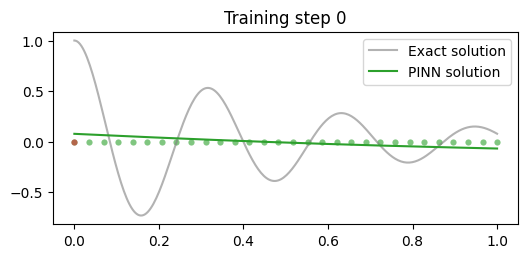

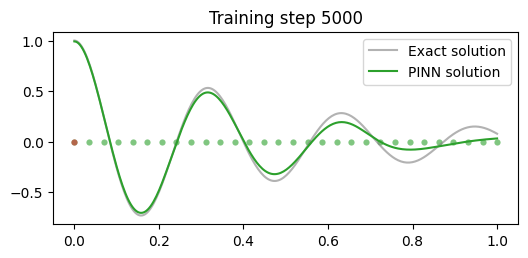

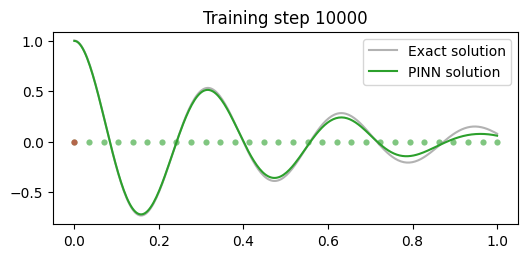

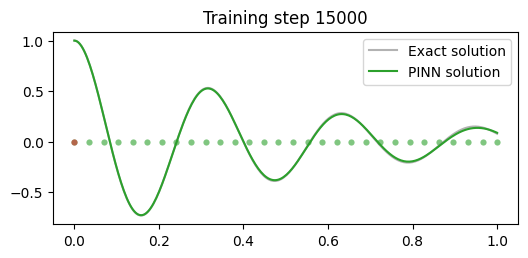

In [13]:
torch.manual_seed(123)

# define network parameters
# 1 input dimension (time)
num_input = 1
# 1 output dimension (displacement)
num_output = 1
# number of neurons and layers
num_neurons = 32
num_layers = 3
# define the physical parameters
d = 2
w0 = 20
m = 1
mu = 2*d*m
k = w0**2*m
# define the hyperparameters
learning_rate = 1e-3
epochs = 15000
lambda1 = 1e-1
lambda2 = 1e-4

# define network
pinn = FCN(num_input, num_output, num_neurons, num_layers)

# define boundary points for the boundary loss
# boundary is x=0, and need to reshape to shape the network expects
# .requires_grad_(True) indicates we want to track the operations involving this tensor for gradient computation
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# define the training points over the entire domain [0,1]
# take 30 time points between t=0 and t=1
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)

# create test points for evaluation
t_test = torch.linspace(0, 1, 300).view(-1,1)
# create the exact solution
u_exact = exact_solution(d,w0,t_test)

# define the optimizer
optimizer = torch.optim.Adam(pinn.parameters(), lr=learning_rate)
for epoch in range(epochs+1):
  # compute the boundary loss by running PINN on the boundary point
  u = pinn(t_boundary) # shape (1,1) since one boundary point
  loss1 = (torch.squeeze(u) - 1)**2 # torch.squeeze turns it into a scalar

  # torch.autograd.grad computes the gradient of u wrt t_boundary using the computation graph
  # need argument torch.ones_like
  # create_graph will hold onto the computation graph used to compute the derivative, which is needed for higher order derivative d2udt2
  dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
  loss2 = (torch.squeeze(dudt) - 0)**2

  # compute the physics loss by running PINN
  u = pinn(t_physics)
  dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
  d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
  # for loss do mean since we have 30 time points in the physics array
  loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

  loss = loss1 + lambda1*loss2 + lambda2*loss3
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  # plot the results
  if epoch % 5000 == 0:
    # runthe PINN on the test data, make sure to do this outside of computation graph
    with torch.no_grad():
      u = pinn(t_test)
      plt.figure(figsize = (6, 2.5))
      # plot the training time coordinates
      plt.scatter(t_physics[:,0], torch.zeros_like(t_physics)[:,0], s=20, lw=0, color='tab:green', alpha=0.6)
      # plot the boundary points
      plt.scatter(t_boundary[:,0], torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color='tab:red', alpha=0.6)
      # plot the true solution curve
      plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color = "tab:grey", alpha=0.6)
      # plot the PINN solution curve
      plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
      plt.title(f'Training step {epoch}')
      plt.legend()
      plt.show()
